In [1]:
# prerequisites
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

import argparse
from torch.optim.lr_scheduler import StepLR

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

bs = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [21]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


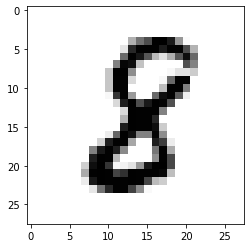

In [22]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
lr = 0.001
epochs = 10

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

**DUAL HEADED**


* Client_1
    * Has Model Segment 1
    * Has the handwritten images segment 1 (vertical distr: left part)
* Client_2
    * Has model Segment 1
    * Has the handwritten images segment 2 (vertical distr: right part)
* Server
    * Has Model Segment 2
    * Has the image labels


In [25]:
import sys
import pytest
import syft as sy
from syft.core.node.common.service.auth import AuthorizationException

import torch as th
from torchvision import datasets, transforms
from torch import nn, optim
import syft as sy
import numpy as np
from syft.util import key_emoji

In [36]:
# create some workers
dev_1 = sy.Device(name="client_1")
dev_2 = sy.Device(name="client_2")
client_1 = dev_1.get_client()
client_2 = dev_2.get_client()

server_dev = sy.Device(name="server")
server = server_dev.get_client()

data_owners = (client_1, client_2)
model_locations = [client_1, client_2, server]

In [43]:
for location in model_locations:
    print(location)
    x = location

<DeviceClient: <SpecificLocation: ef748d768ada45eca67fb3e67bffd003>>
<DeviceClient: <SpecificLocation: ead51b81b7df4a0d83e27bcf41714bc9>>
<DeviceClient: <SpecificLocation: 4002d42f8bae4eb289781252d04330f8>>


In [51]:
model_locations[1].name.split()

'client_2 Client'

In [56]:
input_size= [28*14, 28*14]
hidden_sizes= {"client_1": [32, 64], "client_2":[32, 64], "server":[128, 64]}

#create model segment for each worker
models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2": nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to their segment
optimizers = [
    optim.SGD(models[location.name.split(" ")[0]].parameters(), lr=0.05,)
    for location in model_locations
]

In [55]:



#send model segement to each client and server
for location in model_locations:
    models[location.name.split(" ")[0]].send(location)

Exception: Object <class 'torch.nn.modules.container.Sequential'> has no serializable_wrapper_type

In [14]:
bob_vm = client_1.get_client()

In [15]:
xp = th.tensor([1,2,3]).tag("some", "diabetes", "data")

In [19]:
xp.send(vm_sever_cli)